In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import json
import re
import shutil
import os
from tqdm.auto import tqdm

In [10]:
with open('drive/MyDrive/ScrapedWikiArtImages/canvas_metadata.json', 'r', encoding='utf-8') as f:
    metadata_list = json.load(f)
df = pd.DataFrame(metadata_list)
print(f'Metadata file shape:\n{df.shape}')
print(f'Columns:\n{list(df.columns)}')
df.head()

JSONDecodeError: Expecting ',' delimiter: line 47910 column 888 (char 48875120)

In [11]:
!pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 5.5 MB/s eta 0:00:00


In [12]:
import ijson
import pandas as pd

file_path = 'drive/MyDrive/ScrapedWikiArtImages/canvas_metadata.json'
metadata_list = []

try:
    with open(file_path, 'rb') as f: # Open in binary mode for ijson
        # Assuming the top-level structure is a list of objects.
        # 'item' refers to each element in the top-level list.
        for item in ijson.items(f, 'item'):
            metadata_list.append(item)

    if metadata_list:
        df = pd.DataFrame(metadata_list)
        print(f'Metadata file shape:\n{df.shape}')
        print(f'Columns:\n{list(df.columns)}')
    else:
        print("No se pudo cargar ningún dato válido del archivo JSON usando ijson.")

except ijson.common.IncompleteJSONError as e:
    print(f"Error de JSON incompleto al parsear con ijson: {e}")
    if metadata_list:
        print(f"Se pudieron cargar {len(metadata_list)} objetos antes del error.")
        df = pd.DataFrame(metadata_list)
        print(f'Metadata file shape (parcial):\n{df.shape}')
        print(f'Columns:\n{list(df.columns)}')
    else:
        print("No se pudo cargar ningún objeto válido antes del error.")
except FileNotFoundError:
    print(f"Error: El archivo '{file_path}' no se encontró.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Error de JSON incompleto al parsear con ijson: parse error: premature EOF
                                       
                     (right here) ------^

Se pudieron cargar 47909 objetos antes del error.
Metadata file shape (parcial):
(47909, 21)
Columns:
['Id', 'URL', 'Title', 'OriginalTitle', 'Author', 'AuthorLink', 'Date', 'Styles', 'Series', 'SeriesLink', 'Genre', 'GenreLink', 'Media', 'Location', 'Dimensions', 'Description', 'WikiDescription', 'WikiLink', 'Tags', 'image_urls', 'images']


In [13]:
print(f"Total Number of Artists: {df['Author'].nunique()}")
print(f"Null Artists: {df['Author'].isna().sum()}")

Total Number of Artists: 1078
Null Artists: 0


/tmp/ipython-input-1534793745.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_100_artists_df.index, y=top_100_artists_df.values, palette='viridis')


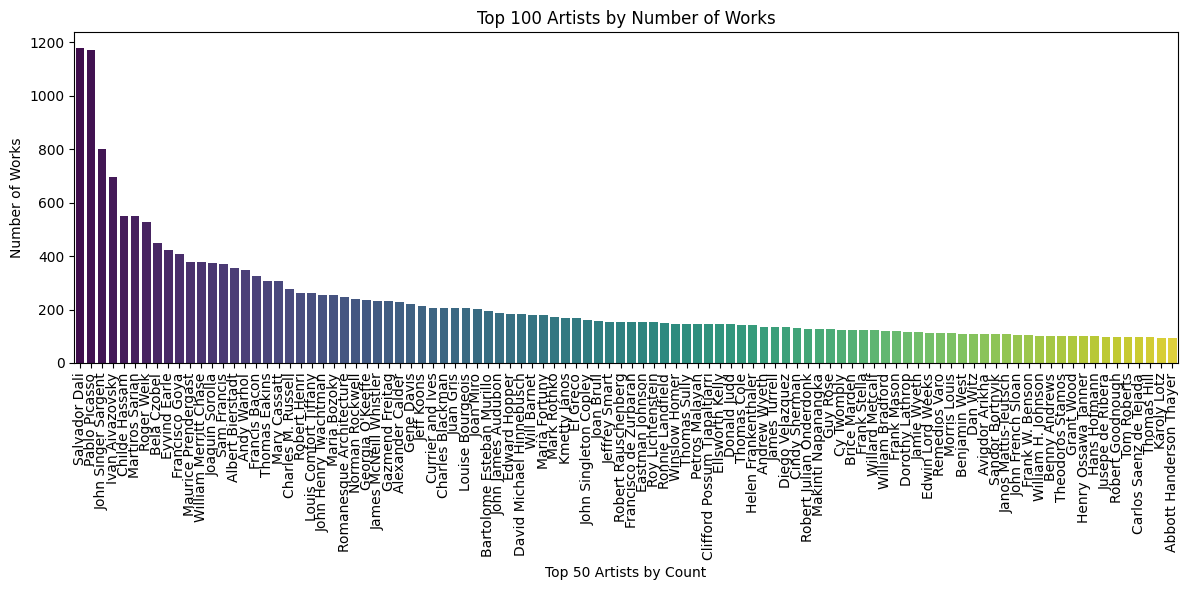

In [14]:
plt.figure(figsize=(12, 6))
top_100_artists_df = df['Author'].value_counts(dropna=True).nlargest(100)
sns.barplot(x=top_100_artists_df.index, y=top_100_artists_df.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Top 50 Artists by Count')
plt.ylabel('Number of Works')
plt.title('Top 100 Artists by Number of Works')
plt.tight_layout()
plt.show()

In [15]:
print(f"Total Number of Styles: {len(df['Styles'])}")
print(f"Null Styles: {df['Styles'].isna().sum()}")

Total Number of Styles: 47909
Null Styles: 0


In [16]:
def extract_primary_style(style_list):
    if isinstance(style_list, list) and len(style_list) > 0:
        first_entry = style_list[0]
        if isinstance(first_entry, list) and len(first_entry) > 0:
            return first_entry[0] # This is the style name
    return None

In [17]:
df_styles = df['Styles'].apply(extract_primary_style)
style_count = df_styles.value_counts()
style_count

,count
Styles,
Impressionism,4601
Expressionism,3790
Abstract Expressionism,3669
Romanticism,3449
Realism,2425
...,...
Renaissance,1
Rayonism,1
Neo-Rococo,1


/tmp/ipython-input-194976659.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=style_count.index, y=style_count.values, palette='viridis')


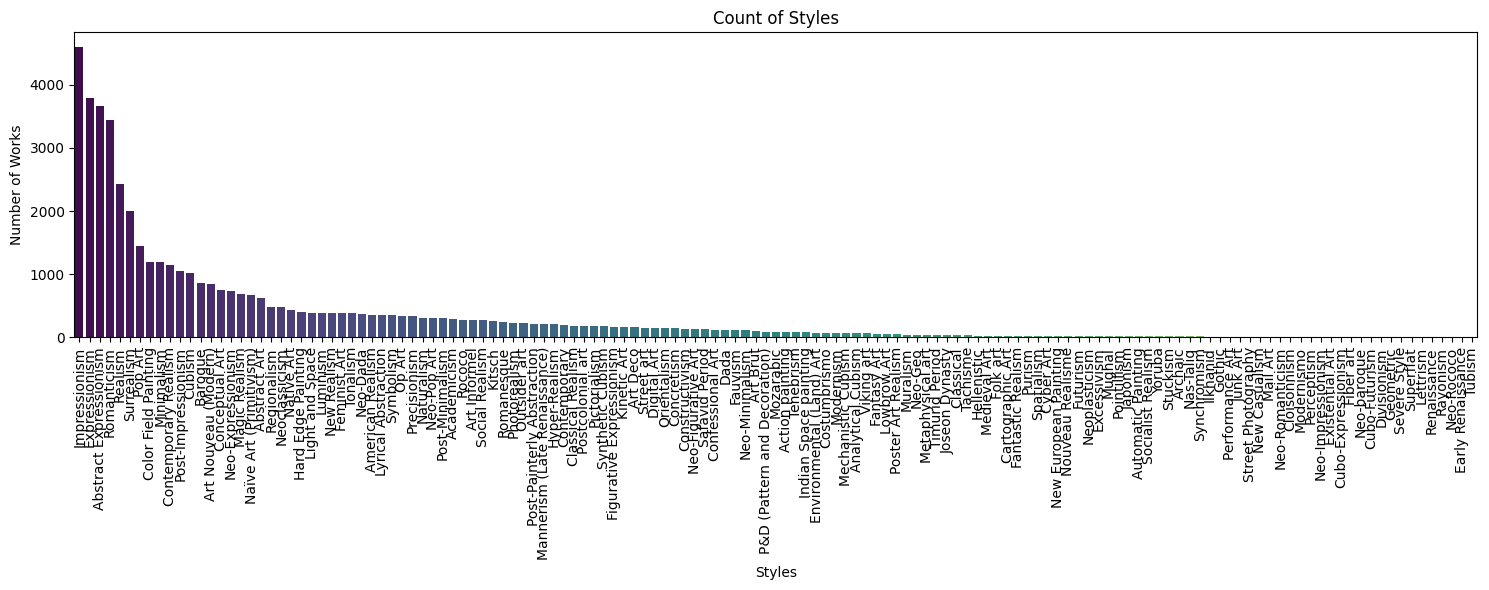

In [18]:
plt.figure(figsize=(15, 6))
style_count = df_styles.value_counts()
sns.barplot(x=style_count.index, y=style_count.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Styles')
plt.ylabel('Number of Works')
plt.title('Count of Styles')
plt.tight_layout()
plt.show()

In [19]:
print(f"Total Number of Entries in 'Media' column: {len(df['Media'])}")
print(f"Null 'Media' entries (actual None): {df['Media'].isna().sum()}")
# Also count entries that are empty lists, as they effectively have no media
empty_list_count = df['Media'].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
print(f"Empty list 'Media' entries: {empty_list_count}")

Total Number of Entries in 'Media' column: 47909
Null 'Media' entries (actual None): 0
Empty list 'Media' entries: 33500


In [20]:
def extract_media_combination(media_data_list):
    """
    Extracts media names from the list of lists, sorts them,
    and returns a comma-separated string of the combination.
    Example input: [['acrylic', 'url1'], ['canvas', 'url2']]
    Example output: "acrylic, canvas"
    """
    if not isinstance(media_data_list, list) or not media_data_list:
        return None # Handles None, empty list, or non-list types

    media_names = []
    for item in media_data_list:
        if isinstance(item, list) and len(item) > 0 and isinstance(item[0], str):
            media_names.append(item[0].strip().lower()) # Standardize: strip whitespace, lowercase
        # else: # Optional: log malformed inner entries
            # print(f"Warning: Malformed media item found: {item}")

    if not media_names:
        return None

    # Sort names to make combinations consistent (e.g., "acrylic, canvas" is same as "canvas, acrylic")
    media_names.sort()
    return ', '.join(media_names)

In [21]:
df_media_combinations = df['Media'].apply(extract_media_combination)

media_combination_counts = df_media_combinations.value_counts(dropna=True) # dropna=True is default but explicit

print("\n--- Unique Media Combinations and their Counts ---")
print(media_combination_counts)

# Plotting the counts
# For better readability, you might want to plot only the top N combinations
top_n = 20 # Adjust as needed
media_combination_counts_top_n = media_combination_counts.head(top_n)


--- Unique Media Combinations and their Counts ---
Series([], Name: count, dtype: int64)


In [22]:
if not media_combination_counts_top_n.empty:
    plt.figure(figsize=(15, 8)) # Adjust figure size as needed
    sns.barplot(x=media_combination_counts_top_n.index, y=media_combination_counts_top_n.values, palette='viridis')
    plt.xticks(rotation=90, ha='right') # Rotate labels for readability
    plt.xlabel('Media Combinations')
    plt.ylabel('Number of Works')
    plt.title(f'Top {top_n} Media Combinations by Count')
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()
else:
    print("\nNo media combinations found to plot (after potential filtering or if all were None).")


No media combinations found to plot (after potential filtering or if all were None).


In [23]:
print(f"Total Number of Genre: {df['Genre'].nunique()}")
print(f"Null Genre: {df['Genre'].isna().sum()}")

Total Number of Genre: 59
Null Genre: 0


/tmp/ipython-input-3884766379.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_count.index, y=genre_count.values, palette='viridis')


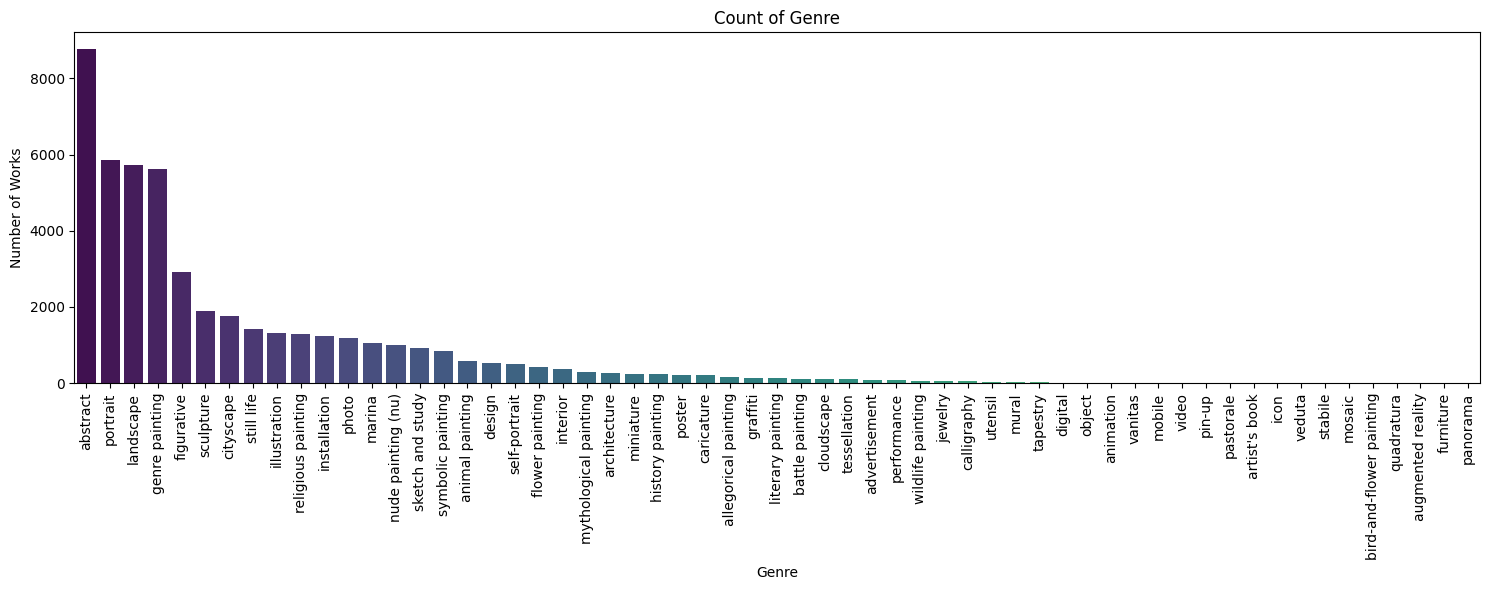

In [24]:
plt.figure(figsize=(15, 6))
genre_count = df['Genre'].value_counts()
sns.barplot(x=genre_count.index, y=genre_count.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Works')
plt.title('Count of Genre')
plt.tight_layout()
plt.show()

In [25]:
year_df = df['Date'].astype(str).str.extract(r'(\d{4})')
type(year_df.value_counts().sort_index())

pandas.core.series.Series

In [26]:
year_count = year_df[0].value_counts().sort_index()
year_count.index

Index(['1000', '1011', '1012', '1030', '1031', '1032', '1040', '1048', '1050',
       '1056',
       ...
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023',
       '2024'],
      dtype='object', name=0, length=453)

In [27]:
decade_series = year_df[0].dropna().astype(int)
decades = (decade_series // 10) * 10

decade_count = decades.value_counts().sort_index()

/tmp/ipython-input-847575295.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decade_count.index, y=decade_count.values, palette='viridis')


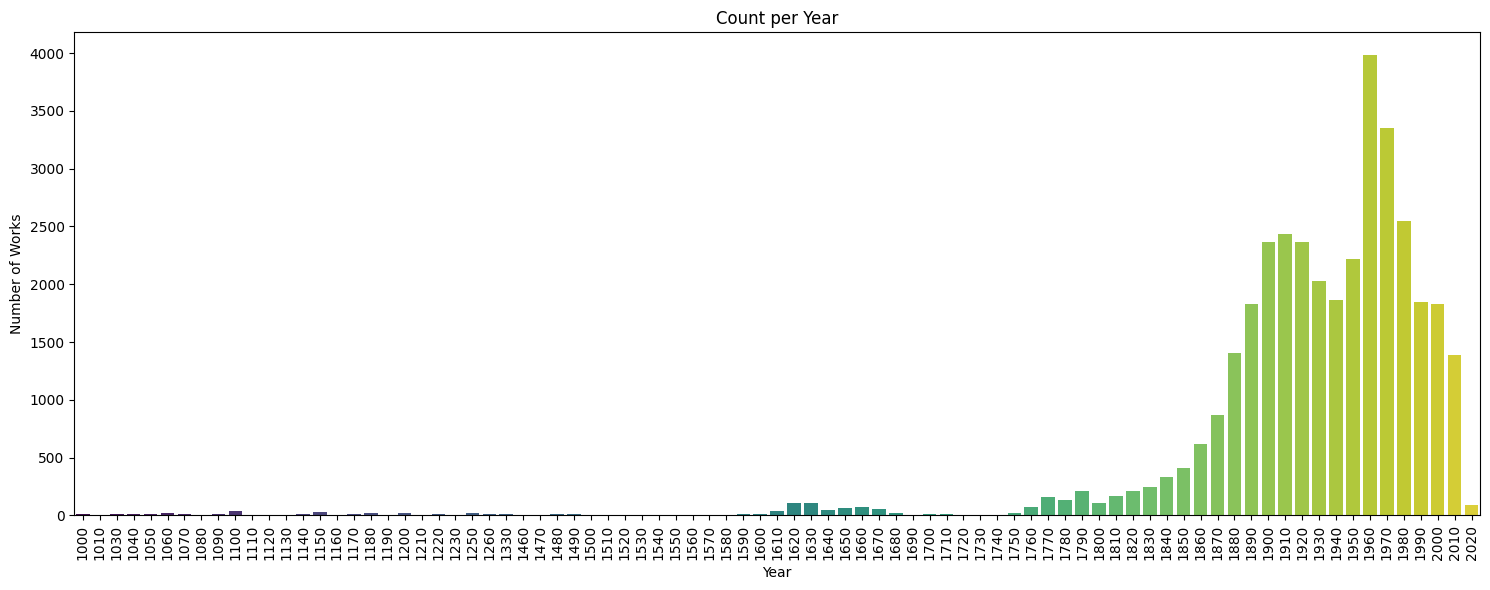

In [28]:
plt.figure(figsize=(15, 6))
year_count = year_df[0].value_counts().sort_index()
sns.barplot(x=decade_count.index, y=decade_count.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of Works')
plt.title('Count per Year')
plt.tight_layout()
plt.show()

In [30]:
dimensions_dict = df.Dimensions.value_counts().to_dict()

In [31]:
# --- Function to parse dimension strings ---
def parse_dimension_string(dim_str):
    """
    Parses a dimension string like "73 x 92 cm" into (height, width).
    Assumes the format is generally "number separator number units".
    Returns (None, None) if parsing fails.
    """
    if pd.isna(dim_str):
        return None, None

    dim_str_cleaned = str(dim_str).lower()
    dim_str_cleaned = re.sub(r'[^\d.x\-]', '', dim_str_cleaned) # Keep digits, '.', 'x', '-'

    # Try splitting by 'x' or '-'
    parts = re.split(r'[x\-]', dim_str_cleaned)

    numeric_parts = []
    for part in parts:
        try:
            if part: # Ensure part is not empty string
                num = float(part)
                if num > 0: # Dimensions should be positive
                    numeric_parts.append(num)
        except ValueError:
            continue

    if len(numeric_parts) >= 2:
        # Assuming convention: Height x Width (or first found is H, second is W)
        return numeric_parts[0], numeric_parts[1]
    elif len(numeric_parts) == 1:
        # If only one dimension, could be diameter or side of a square.
        # For now, assign to height and leave width None, or handle as per your convention.
        return numeric_parts[0], None
    return None, None

In [32]:
# --- Unroll the data based on counts ---
all_heights = []
all_widths = []
all_aspect_ratios = []

for dim_string, count in dimensions_dict.items():
    height, width = parse_dimension_string(dim_string)

    if height is not None and width is not None:
        aspect_ratio = height / width if width > 0 else 0 # Or width / height depending on convention

        all_heights.extend([height] * count)
        all_widths.extend([width] * count)
        all_aspect_ratios.extend([aspect_ratio] * count)
        # print(f"Parsed: '{dim_string}' -> H:{height}, W:{width}, AR:{aspect_ratio}, Count:{count}")
    elif height is not None and width is None: # Case where only one dimension was parsed
        # Decide how to handle this - e.g. assume square, or skip aspect ratio
        all_heights.extend([height] * count)
        all_widths.extend([None] * count) # Or [height]*count if assuming square
        # all_aspect_ratios.extend([1.0] * count) # If assuming square
        print(f"Parsed (only height): '{dim_string}' -> H:{height}, Count:{count}")
    else:
        print(f"Warning: Could not parse dimension string: '{dim_string}'")

In [33]:
num_missing_heights = sum(h is None for h in all_heights)
num_missing_widths = sum(w is None for w in all_widths)
print(f"Missing heights: {num_missing_heights}")
print(f"Missing widths: {num_missing_widths}")

Missing heights: 0
Missing widths: 0



--- Descriptive Statistics for Parsed Dimensions ---
Height statistics:
count    10249.000000
mean        96.953235
std        611.337934
min          1.000000
25%         40.500000
50%         65.000000
75%        111.400000
max      45992.000000
Name: image_height, dtype: float64

Width statistics:
count    10249.000000
mean       107.744816
std        850.330396
min          1.260000
25%         41.280000
50%         65.000000
75%        102.000000
max      40785.000000
Name: image_width, dtype: float64

Aspect Ratio (W/H) statistics:
count    10249.000000
mean         1.825726
std         36.117020
min          0.000207
25%          0.745435
50%          0.923077
75%          1.332787
max       2376.155539
Name: aspect_ratio_wh, dtype: float64


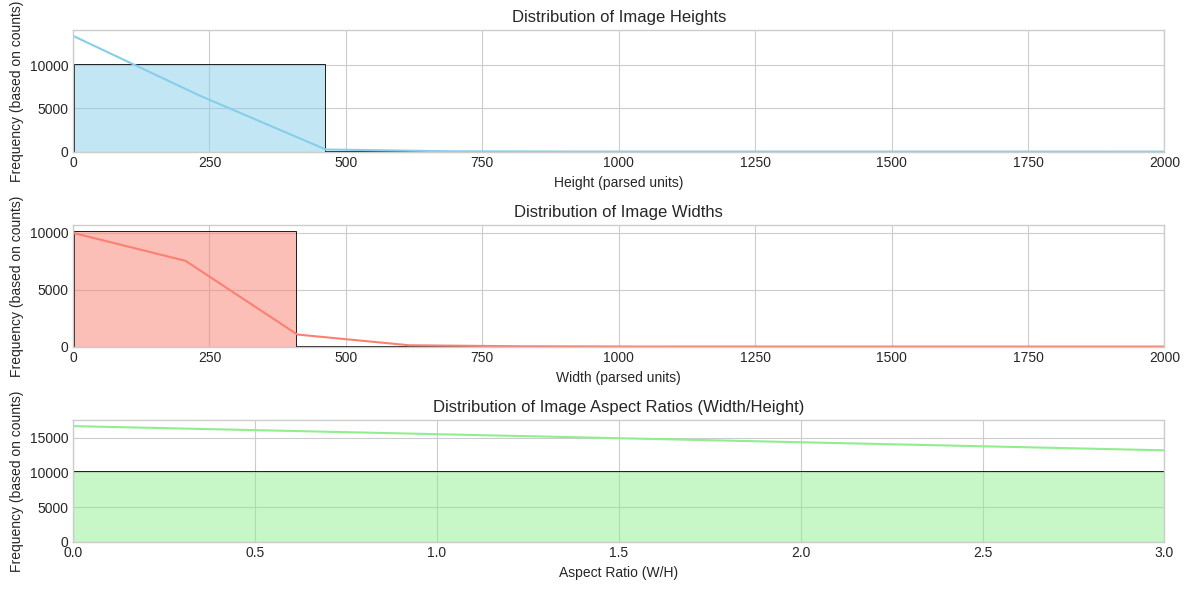

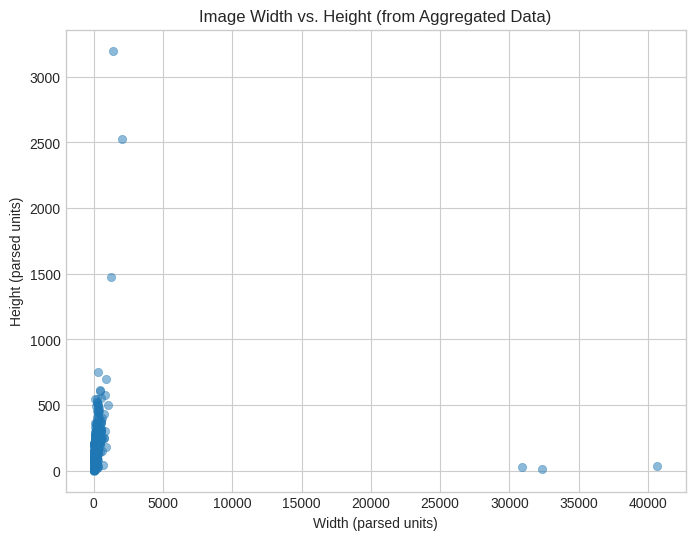

In [34]:
# Create a DataFrame from the unrolled data
if all_heights: # Check if any data was successfully parsed
    parsed_df = pd.DataFrame({
        'image_height': all_heights,
        'image_width': all_widths,
        'aspect_ratio': all_aspect_ratios # Will contain NaNs if width was None
    })
    parsed_df.dropna(subset=['image_height', 'image_width'], inplace=True) # Ensure both H and W for aspect ratio analysis

    # Recalculate aspect ratio for the cleaned DataFrame
    # Assuming convention: Width / Height for aspect ratio plots generally
    parsed_df['aspect_ratio_wh'] = parsed_df['image_width'] / parsed_df['image_height']


    print("\n--- Descriptive Statistics for Parsed Dimensions ---")
    print("Height statistics:")
    print(parsed_df['image_height'].describe())
    print("\nWidth statistics:")
    print(parsed_df['image_width'].describe())
    print("\nAspect Ratio (W/H) statistics:")
    print(parsed_df['aspect_ratio_wh'].describe())

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')

    # Histograms
    fig, axes = plt.subplots(3, 1, figsize=(12, 6))

    sns.histplot(parsed_df['image_height'], kde=True, ax=axes[0], color='skyblue', bins=100)
    axes[0].set_title('Distribution of Image Heights')
    axes[0].set_xlabel('Height (parsed units)')
    axes[0].set_ylabel('Frequency (based on counts)')
    axes[0].set_xlim(0, 2000)  # Adjust as needed

    sns.histplot(parsed_df['image_width'], kde=True, ax=axes[1], color='salmon', bins=100)
    axes[1].set_title('Distribution of Image Widths')
    axes[1].set_xlabel('Width (parsed units)')
    axes[1].set_ylabel('Frequency (based on counts)')
    axes[1].set_xlim(0, 2000)  # Adjust as needed

    sns.histplot(parsed_df['aspect_ratio_wh'], kde=True, ax=axes[2], color='lightgreen', bins=100)
    axes[2].set_title('Distribution of Image Aspect Ratios (Width/Height)')
    axes[2].set_xlabel('Aspect Ratio (W/H)')
    axes[2].set_ylabel('Frequency (based on counts)')
    # Optional: Limit x-axis for aspect ratio if outliers are too extreme
    axes[2].set_xlim(0, 3)


    plt.tight_layout()
    plt.show()

    # Scatter plot of Width vs Height
    plt.figure(figsize=(8, 6))
    # Use a sample if the dataset is very large after unrolling to avoid overplotting
    sample_df = parsed_df.sample(n=min(5000, len(parsed_df)), random_state=1) if len(parsed_df) > 5000 else parsed_df

    sns.scatterplot(x='image_width', y='image_height', data=sample_df, alpha=0.5, edgecolor=None)
    plt.title('Image Width vs. Height (from Aggregated Data)')
    plt.xlabel('Width (parsed units)')
    plt.ylabel('Height (parsed units)')
    plt.show()

else:
    print("\nNo valid dimension data could be parsed and unrolled from the input.")